# Sentiment Analysis of Twitter Posts
<!-- Notebook name goes here -->
<center><b>Notebook: Multinomial Logistic Regression, Error Analysis, and Tuning</b></center>
<br>

**By**: Stephen Borja, Justin Ching, Erin Chua, and Zhean Ganituen.

**Dataset**: Hussein, S. (2021). Twitter Sentiments Dataset [Dataset]. Mendeley. https://doi.org/10.17632/Z9ZW7NT5H2.1

**Motivation**: Every minute, social media users generate a large influx of textual data on live events. Performing sentiment analysis on this data provides a real-time view of public perception, enabling quick insights into the general population’s opinions and reactions.

**Goal**: By the end of the project, our goal is to create and compare supervised learning algorithms for sentiment analysis.

W. P. Ramadhan, S. T. M. T. Astri Novianty and S. T. M. T. Casi Setianingsih, "Sentiment analysis using multinomial logistic regression," 2017 International Conference on Control, Electronics, Renewable Energy and Communications (ICCREC), Yogyakarta, Indonesia, 2017, pp. 46-49, doi: 10.1109/ICCEREC.2017.8226700. keywords: {Testing;Logistics;Training;Feature extraction;Training data;Sentiment analysis;Social network services;twitter;multinomial logistic regression;text mining;softmax regression},

^^ ref used

# **1. Project Set-up**



In [101]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score,
    GridSearchCV
)
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    log_loss
)
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath("../lib"))
from bag_of_words import BagOfWordsModel


# **2. Data Set-up**

In [102]:
import IPython.core.page
import builtins
from IPython.utils.capture import capture_output

pager = IPython.core.page.page
helper = builtins.help

IPython.core.page.page = lambda *args, **kwargs: None
builtins.help = lambda *args, **kwargs: None

try:
    with capture_output():
        %run data.ipynb
finally:
    IPython.core.page.page = pager
    builtins.help = helper

print("Data Setup is DONE")

# Tests
assert X.shape == (162_801, 29318), "Feature matrix shape is wrong; expected (162_801, 29318)"
assert y.shape == (162_801,), "Labels shape is wrong; expected (162_801,)"

assert X_train.shape == (113_960, 29_318), "Train shape is wrong; expected (113_960, 2)"
assert X_test.shape == (48_841, 29_318), "Test shape is wrong; expected (48_841, 2)"

assert y_train.shape == (113_960,), "Train labels shape is wrong; expected (113_960,)"
assert y_test.shape == (48_841,), "Test labels shape is wrong; expected (48_841,)"
print("All tests passed.")

Data Setup is DONE
All tests passed.


### Reading the data

After the cleaning process

In [103]:
df = pd.read_csv("../data/data_post_lemma.csv")
df.head()

,clean_text,category,clean_ours,lemmatized
0,when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples,-1,when modi promised minimum government maximum governance expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples,when modi promise minimum government maximum governance expect he begin the difficult job reform the state why do take year get justice state should and not business and should exit psus and temple
1,talk all the nonsense and continue all the drama will vote for modi,0,talk all the nonsense and continue all the drama will vote for modi,talk all the nonsense and continue all the drama will vote for modi
2,what did just say vote for modi welcome bjp told you rahul the main campaigner for modi think modi should just relax,1,what did just say vote for modi welcome bjp told you rahul the main campaigner for modi think modi should just relax,what do just say vote for modi welcome bjp tell you rahul the main campaigner for modi think modi should just relax
3,asking his supporters prefix chowkidar their names modi did great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuses are coming from chowkidars,1,asking his supporters prefix chowkidar their names modi did great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuses are coming from chowkidars,ask his supporter prefix chowkidar their name modi do great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuse be come from chowkidar
4,answer who among these the most powerful world leader today trump putin modi may,1,answer who among these the most powerful world leader today trump putin modi may,answer who among these the most powerful world leader today trump putin modi may


In [104]:
df = df[["lemmatized", 'category']]
df.head()

,lemmatized,category
0,when modi promise minimum government maximum governance expect he begin the difficult job reform the state why do take year get justice state should and not business and should exit psus and temple,-1
1,talk all the nonsense and continue all the drama will vote for modi,0
2,what do just say vote for modi welcome bjp tell you rahul the main campaigner for modi think modi should just relax,1
3,ask his supporter prefix chowkidar their name modi do great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuse be come from chowkidar,1
4,answer who among these the most powerful world leader today trump putin modi may,1


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162942 entries, 0 to 162941
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   lemmatized  162942 non-null  object
 1   category    162942 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.5+ MB


# **3. Model Selection**

In [106]:
model = LogisticRegression()

# **4. Training the Model**

Here we assign the 

In [107]:
X = df["lemmatized"]
y = df["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7)

To check if the data separated according to the test and training size, we can check the length of `X_train` and `X_test`

In [108]:
len(X_train)

114059

In [109]:
len(X_test)

48883

In [110]:
BoW = BagOfWordsModel(X_train, min_freq=5)
X_train_vec = BoW.matrix
X_test_vec = BoW.vectorizer.transform(X_test)

C:\Users\Erin\Documents\GITHUB\STINTSY-Order-of-Erin\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [111]:
model.fit(X_train_vec, y_train)

C:\Users\Erin\Documents\GITHUB\STINTSY-Order-of-Erin\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

### Evaluation

In [112]:
model.score(X_test_vec, y_test)

0.8902072295071907

In [113]:
y_true = y_test
y_pred = model.predict(X_test_vec)

In [114]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

In [115]:
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.8902
Precision: 0.8898
Recall:    0.8902
F1 Score:  0.8896


### Error Analysis

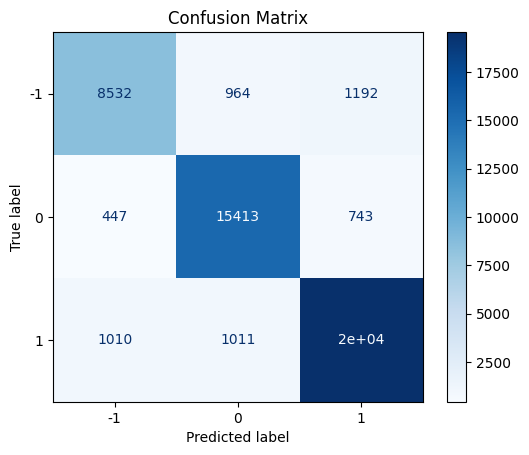

In [116]:
cm = ConfusionMatrixDisplay.from_predictions(
    y_true, 
    y_pred,
    cmap='Blues',
    display_labels=[-1, 0, 1]
)
plt.title('Confusion Matrix')
plt.show()

In [117]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.85      0.80      0.83     10688
           0       0.89      0.93      0.91     16603
           1       0.91      0.91      0.91     21592

    accuracy                           0.89     48883
   macro avg       0.88      0.88      0.88     48883
weighted avg       0.89      0.89      0.89     48883



In [118]:
y_prob = model.predict_proba(X_test_vec)
print(log_loss(y_true, y_prob))

0.34487629115570095


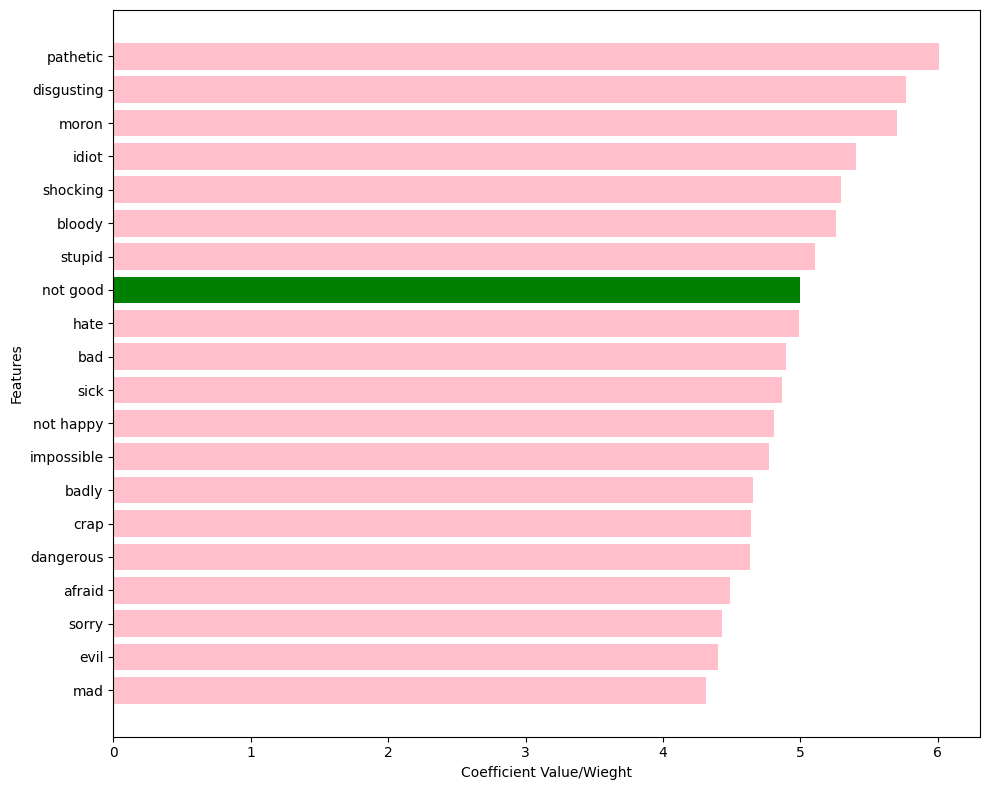

In [119]:
feature_names = BoW.feature_names
all_coefs = model.coef_
class_labels = model.classes_

coefficients = model.coef_[0]

top_n = 20
top_indices = np.argsort(np.abs(coefficients))[-top_n:]
top_features = feature_names[top_indices]
top_coefs = coefficients[top_indices]

colors = []
for idx in top_indices:
    feature_coefs = all_coefs[:, idx]
    max_class_idx = np.argmax(np.abs(feature_coefs))
    strongest_class = class_labels[max_class_idx]
    
    if strongest_class == -1:
        colors.append('pink') # negative sentiment, or -1 (also its pink and not red cuz the red burns my eyes)
    elif strongest_class == 0:
        colors.append('gray') # neutral sentiment, or 0
    else:
        colors.append('green') # positive sentiment, or 1

plt.figure(figsize=(10, 8))
plt.barh(range(top_n), top_coefs, color=colors)
plt.yticks(range(top_n), top_features)
plt.xlabel('Coefficient Value/Wieght')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

Top 20 words/features with the most weight shows its mostly of negative sentiment, it could be that the dataset it was trained on was imbalanced (with less instances of negative sentiments) leading to features with negative sentiment havinf higher copefficient values during BoW ?

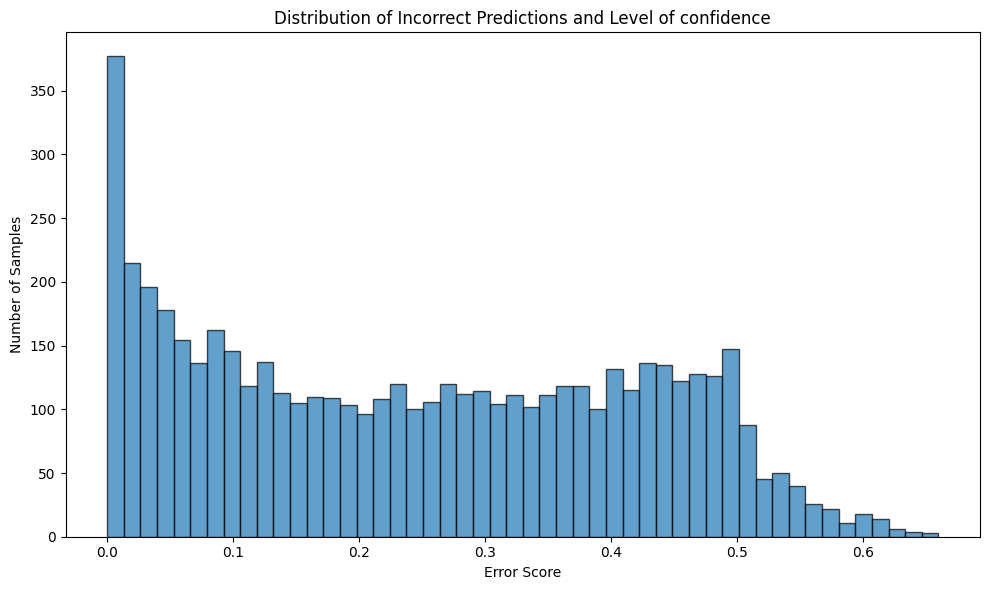

Total incorrect predictions: 5367/48883
Mean error score: 0.246


In [120]:
confidence = y_prob.max(axis=1)

incorrect_mask = y_pred != y_test.values
incorrect_confidence = confidence[incorrect_mask]

plt.figure(figsize=(10, 6))
plt.hist(1 - incorrect_confidence, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Error Score')
plt.ylabel('Number of Samples')
plt.title('Distribution of Incorrect Predictions and Level of confidence')
plt.tight_layout()
plt.show()

print(f"Total incorrect predictions: {incorrect_mask.sum()}/{len(y_pred)}")
print(f"Mean error score: {(1 - incorrect_confidence).mean():.3f}")

Most of the errors here have a low error score (and low mean error score) indicating high confidence for the wrong class prediction

In [121]:
pipeline = Pipeline([
    ('bow', CountVectorizer(min_df=5, tokenizer=str.split, ngram_range=(1, 2))),
    ('classifier', LogisticRegression(solver='lbfgs',max_iter=1000))
])

cv_scores = cross_val_score(pipeline, X, y, cv=5)

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

C:\Users\Erin\Documents\GITHUB\STINTSY-Order-of-Erin\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Erin\Documents\GITHUB\STINTSY-Order-of-Erin\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Erin\Documents\GITHUB\STINTSY-Order-of-Erin\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Erin\Documents\GITHUB\STINTSY-Order-of-Erin\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Erin\Documents\GITHUB\STINTSY-Order-of-Erin\.venv\Lib\site-packages\sklearn\feature_extract

Cross-validation scores: [0.87937648 0.89536347 0.88894685 0.88385295 0.88268688]
Mean CV Accuracy: 0.8860 (+/- 0.0112)


# **5. Model Tuning**

following what Ramadhan et al. (2017) did and add use Bag of Words for word groupings then TF-IDF for feature extraction


In [122]:
# BoW = BagOfWordsModel(X_train, min_freq=5)
# X_train_BoW = BoW.matrix
# X_test_BoW = BoW.vectorizer.transform(X_test)

In [123]:
# transformer = TfidfTransformer()
# X_train_Tfidf = transformer.fit_transform(X_train_BoW)
# X_test_Tfidf = transformer.fit_transform(X_test_BoW)

In [124]:
# X_train_BoW.shape

In [125]:
# X_test_BoW.shape

In [126]:
# len(BoW.feature_names)

In [127]:
# model = LogisticRegression(max_iter=1000)
# model.fit(X_train_Tfidf, y_train)

In [128]:
# model.score(X_test_Tfidf, y_test)